# Task04 基于相似度的方法
## 1 知识梳理

### 1.1 基于距离的度量
- 适用范围：多维数值数据、分类数据、文本数据、时间序列数据和序列数据
- 前提假设：异常点的$k$近邻距离要远大于正常点

#### 1.1.1 基于单元的方法
数据空间被划分为单元格，每个维度被划分成宽度最多为$\frac{D}{2\sqrt{d}}$单元格  
异常点判断规则：
- 如果一个单元格中包含超过$k$个数据点及其$L_1$邻居，那么这些数据点都不是异常值。
- 如果单元$A$及其相邻$L_1$和$L_2$中包含少于$k$个数据点，则单元$A$中的所有点都是异常值。
- 如果不在上述两种情况下，计算该点的$k$最近邻距离：  
  1. 对于那些在$L_1$和$L_2$中不超过$k$个且距离小于$D$的数据点，可标记为异常值 
  2. 仅需要计算单元$A$中的点到单元$A$的$L_2$邻居中的点的距离 

#### 1.1.2 基于索引的方法
- 利用多维索引结构（如`R`树、`k-d`树）来搜索每个数据对象$A$在半径$D$范围内的相邻点
- 算法的时间复杂度在最坏情况下为$O(kN^2)$，其中$k$是数据集维度，$N$是数据集包含对象的个数
- 具有较好的扩展性
- 构造索引需要密集复杂的计算量

### 1.2 基于密度的度量
&emsp;&emsp;算法主要有局部离群因子(`LocalOutlierFactor`, `LOF`)，以及`LOCI`、`CLOF`等基于`LOF`的改进算法

#### 1.2.1 $k$-距离
&emsp;&emsp;对于数据集$D$中的某一个对象$o$，与其距离最近的$k$个相邻点的最远距离表示为`k-distance(o)`，定义为给定点$o$和数据集$D$中对象$p$之间的距离$d(o,p)$，满足：  
- 在集合$D$中至少有$k$个点$p'$，其中$p' \in D \backslash \{o\}$，满足$d(o,p') \leqslant d(o, p)$
- 在集合$D$中最多有$k-1$个点$p'$，其中$p' \in D \backslash \{o\}$，满足$d(o,p') < d(o, p)$

&emsp;&emsp;以对象$o$为中心，对数据集$D$中的所有点到$o$的距离进行排序(从近到远)，距离对象$o$第$k$近的点$p$与$o$之间的距离就是对象$0$的$k$-距离。

#### 1.2.2 $k$-领域
- 概念：到对象$o$的距离小于等于$k$-距离的所有点的集合
- 数学表达：$N_{\text{k-distance}(o)}(o) = {p \in D \backslash \{o\} | d(o,p) \leqslant \text{k-distance}(o) }$
- 几何意义：对象$o$的$k$-领域是以对象$o$为圆心，$k$-距离为半径围成的圆形区域

#### 1.2.3 可达距离
- 将数据集$D$内的点到$o$的距离分为两类：
    1. 若$p_i$在对象$o$的$k$-邻域内，则可达距离就是给定点$p$关于对象$o$的$k$-距离
    2. 若$p_i$在对象$o$的$k$-邻域外，则可达距离就是给定点$p$关于对象$o$的实际距离
- 数学表达：$\text{reach-dist}_k(p,o) = \max\{ \text{k-distance}(o), d(p,o)\}$

#### 1.2.4 局部可达密度
- 点与点之间距离越短，密度越大
- 数学定义：$$\text{lrd}_{\text{MinPts}}(p) = 1 / ( \displaystyle \frac{\displaystyle \sum_{\displaystyle o \in N_{ \text{MinPts}}(p)} \text{reach-dist}_{\text{MinPts}}(p, o)}{|N_{\text{MinPts}}(p)|})$$
- 异常点判定条件：给定点$p$的局部可达密度越高，越可能与其邻域内的点属于同一簇；密度越低，越可能是离群点

#### 1.2.5 局部异常因子
- 数学定义：$$
L O F_{\text{MinPts}}(p)=\frac{\displaystyle \sum_{\displaystyle o \in N_{\text{MinPts}}(p)} 
\frac{\text{lrd}_{\text{MinPtx}}(o)}{\text{lrd}_{\text{MinPts}}(p)}}{\left|N_{\text{MinPts}}(p)\right|}$$
- 描述：表示点$p$的领域$N_k(p)$内其他点的局部可达密度与点$p$的局部可达密度之比的平均数
- 如果这个比值接近1，说明点$o$的邻域点密度超不多，点$o$和领域中的点属于同一簇
- 如果这个比值小于1，说明点$o$的密度高度高于其邻域点密度，则为密集点
- 如果这个比值大于1，说明点$o$的密度小于其领域点密度，则为异常点

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
np.random.seed(61)

# 构造两个数据点集群
X_inliers1 = 0.2 * np.random.randn(100, 2)
X_inliers2 = 0.5 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers1 + 2, X_inliers2 - 2]

# 构造一些离群的点
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# 拼成训练集
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
# 打标签，群内点构造离群值为1，离群点构造离群值为-1
ground_truth[-n_outliers:] = -1

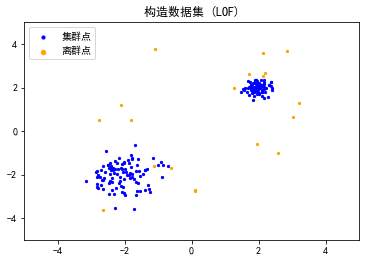

In [3]:
plt.title('构造数据集 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

使用LocalOutlierFactor库对构造数据集进行训练，得到训练的标签和训练分数（局部离群值）。

In [5]:
# 训练模型（找出每个数据的实际离群值）
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# 对单个数据集进行无监督检测时，以1和-1分别表示非离群点与离群点
y_pred = clf.fit_predict(X)

# 找出构造离群值与实际离群值不同的点
n_errors = y_pred != ground_truth
X_pred = np.c_[X,n_errors]
X_scores = clf.negative_outlier_factor_

# 实际离群值有正有负，转化为正数并保留其差异性（不是直接取绝对值）
X_scores_nor = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
X_pred = np.c_[X_pred,X_scores_nor]
X_pred = pd.DataFrame(X_pred,columns=['x','y','pred','scores'])
X_pred_same = X_pred[X_pred['pred'] == False]
X_pred_different = X_pred[X_pred['pred'] == True]

# 直观地看一看数据
X_pred.head()

,x,y,pred,scores
0,1.913701,2.087875,0.0,0.000494
1,1.999748,2.212225,0.0,0.005255
2,2.040673,2.133115,0.0,0.001521
3,1.791277,1.743218,0.0,0.015652
4,1.991693,1.770405,0.0,0.010113


将训练分数（离群程度）用圆直观地表示出来，并对构造标签与训练标签不一致的数据用不同颜色的圆进行标注。

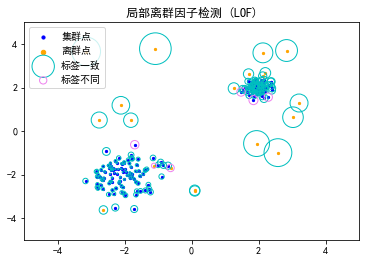

In [15]:
plt.title('局部离群因子检测 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

# 以标准化之后的局部离群值为半径画圆，以圆的大小直观表示出每个数据点的离群程度
plt.scatter(X_pred_same.values[:,0], X_pred_same.values[:, 1],
            s=1000 * X_pred_same.values[:, 3], edgecolors='c',
            facecolors='none', label='标签一致')
plt.scatter(X_pred_different.values[:, 0], X_pred_different.values[:, 1], 
            s=1000 * X_pred_different.values[:, 3], edgecolors='violet', 
            facecolors='none', label='标签不同')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

可以看出，模型成功区分出了大部分的离群点，一些因为随机原因散落在集群内部的“离群点”也被识别为集群内部的点，但是一些与集群略为分散的“集群点”则被识别为离群点。

## 2 练习
学习使用PyOD库生成toy example并调用LOF算法